In [1]:
import torch
import numpy as np
import random
import os
import pickle
import time
import matplotlib.pyplot as plt
from scipy.stats import zscore, rankdata
import torch.optim

from SAC_deepQnet import SACAgent

from SAC_evaluate import do_eval, do_test

import matplotlib.pyplot as plt

In [2]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

# =========================== small function===============================
from scipy.stats import zscore, rankdata


def my_zscore(x):
    return zscore(x, ddof=1), np.mean(x, axis=0), np.std(x, axis=0, ddof=1)


In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
# from sklearn.preprocessing import MinMaxScaler
seed = 42

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
if __name__ == '__main__':
    start = time.perf_counter()
    with open('step_4_start_mimiciv_try.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)

    ##################### Pengaturan parameter model##############################
    # Training Parameters
    num_epoch = 151
    gamma = 0.99
    beat1 = 0
    beat2 = 0.6
    beta3 = 0.3
    lr = 3e-5
    reward_value = 24
    beta = [beat1, beat2, beta3]
    icustayidlist = MIMICtable['stay_id']
    # list of unique icustayids from MIMIC unique icustayid list
    icuuniqueids = np.unique(icustayidlist)
    reformat5 = MIMICtable.values.copy()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('####  generated state  ####')

    # -----------------------Filtered features = 37--------------------------------
    colnorm = ['SOFA', 'age', 'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'Temp_C',
               'Sodium', 'Chloride', 'Glucose', 'Calcium', 'Hb', 'WBC_count', 'Platelets_count',
               'PTT', 'PT', 'Arterial_pH', 'paO2', 'paCO2', 'HCO3', 'Arterial_lactate', 'Shock_Index',
               'PaO2_FiO2', 'cumulated_balance', 'CO2_mEqL', 'Ionised_Ca']
    # 8个指标
    collog = ['SpO2', 'BUN', 'Creatinine', 'SGOT',
              'Total_bili', 'INR', 'input_total', 'output_total']

    colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
    collog = np.where(np.isin(MIMICtable.columns, collog))[0]

    scaleMIMIC = np.concatenate([zscore(reformat5[:, colnorm], ddof=1),
                                 zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

    # scaleMIMIC = zscore(reformat5[:, colnorm], ddof=1)

    train = np.load('train_mimiciv.npy')
    validat = np.load('validation_mimiciv.npy')
    test = np.load('test_mimiciv.npy')

    Xvalidat = scaleMIMIC[validat, :]
    blocsvalidat = reformat5[validat, 0]
    ptidvalidat = reformat5[validat, 1]

    Xtrain = scaleMIMIC[train, :]
    Xtest = scaleMIMIC[test, :]
    blocstrain = reformat5[train, 0]  # Serial number
    bloctest = reformat5[test, 0]
    ptidtrain = reformat5[train, 1]  # Patient number
    ptidtest = reformat5[test, 1]

    # *************************
    RNNstate = Xtrain  # ***

    print('####  Generating Actions  ####')

    # --- Ambil kolom indeks IV dan vasopressor ---
    iol = MIMICtable.columns.get_loc('input_4hourly')      # IV fluid column
    vcl = MIMICtable.columns.get_loc('max_dose_vaso')      # Vasopressor column

    # Ambil nilai mentah (raw)
    iv_raw = reformat5[:, iol].reshape(-1, 1)
    vaso_raw = reformat5[:, vcl].reshape(-1, 1)

    # Lakukan log1p transform (lebih aman untuk data dengan nol)
    iv_log = np.log1p(iv_raw)
    vaso_log = np.log1p(vaso_raw)

    # Hitung mean dan std di domain log
    mean_log_iv = iv_log.mean()
    std_log_iv = iv_log.std(ddof=1)

    mean_log_vaso = vaso_log.mean()
    std_log_vaso = vaso_log.std(ddof=1)

    # Normalisasi dengan z-score
    iv_norm = (iv_log - mean_log_iv) / std_log_iv
    vaso_norm = (vaso_log - mean_log_vaso) / std_log_vaso

    # Gabungkan sebagai continuous action
    continuous_actions = np.concatenate([iv_norm, vaso_norm], axis=1)

    # Simpan untuk inverse transform saat inference
    norm_stats = {
        "mean_log_iv": float(mean_log_iv),
        "std_log_iv": float(std_log_iv),
        "mean_log_vaso": float(mean_log_vaso),
        "std_log_vaso": float(std_log_vaso)
    }
    with open('SAC-algorithm/action_norm_stats.pkl', 'wb') as f:
        pickle.dump(norm_stats, f)

    # Split actions untuk train/valid/test
    actionbloctrain = continuous_actions[train]
    actionblocvalidat = continuous_actions[validat]
    actionbloctest = continuous_actions[test]

    # =================incentives============================
    print('####  Generate Rewards  ####')
    outcome = 9
    Y90 = reformat5[train, outcome]
    reward_value = 24
    r = np.array([reward_value, -reward_value]).reshape(1, -1)
    r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1)  #  Skor reward

    # -----Incentive function preparation-----------------------------
    SOFA = reformat5[train, 57]  # ***
    R3 = r2[:, 0]
    R4 = (R3 + reward_value) / (2 * reward_value)
    c = 0
    bloc_max = max(blocstrain)

    # ================Build state & & next state sequence lists Generate strategy trajectories=================================
    print(RNNstate.shape[0])

    print('####  Generate trajectory  ####')
    statesize = int(RNNstate.shape[1])
    states = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    actions = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 2), dtype=np.float32)
    next_actions = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 2), dtype=np.float32)
    rewards = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    next_states = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    done_flags = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    bloc_num = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    blocnum1 = 1

    bloc_num_reward = 0
    for i in range(RNNstate.shape[0] - 1):  # Each line of the cycle
        states[c] = RNNstate[i, :]
        actions[c] = actionbloctrain[i]
        bloc_num[c] = blocnum1
        if (blocstrain[i + 1] == 1):  # end of trace for this patient
            next_states1 = np.zeros(statesize)
            next_actions1 = -1
            done_flags1 = 1
            blocnum1 = blocnum1 + 1
            bloc_num_reward += 1
            reward1 = -beat1 * (SOFA[i]) + R3[i]
            bloc_num_reward = 0
        else:
            next_states1 = RNNstate[i + 1, :]
            next_actions1 = actionbloctrain[i + 1]
            done_flags1 = 0
            blocnum1 = blocnum1
            reward1 = - beat2 * (SOFA[i + 1] - SOFA[i])
            bloc_num_reward += 1
        next_states[c] = next_states1
        next_actions[c] = next_actions1
        rewards[c] = reward1
        done_flags[c] = done_flags1
        c = c + 1
    states[c] = RNNstate[c, :]
    actions[c] = actionbloctrain[c]
    bloc_num[c] = blocnum1

    next_states1 = np.zeros(statesize)
    next_actions1 = -1
    done_flags1 = 1
    blocnum1 = blocnum1 + 1
    bloc_num_reward += 1
    reward1 = -beat1 * (SOFA[c]) + R3[c]

    bloc_num_reward = 0
    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    c = c + 1

    bloc_num[c] = blocnum1
    bloc_num = bloc_num[:c, :]
    states = states[: c, :]
    next_states = next_states[: c, :]
    actions = actions[: c, :]
    next_actions = next_actions[: c, :]
    rewards = rewards[: c, :]
    done_flags = done_flags[: c, :]
    bloc_num = np.squeeze(bloc_num)
    actions = np.squeeze(actions)
    rewards = np.squeeze(rewards)
    done_flags = np.squeeze(done_flags)
    batch_size = 16
    state = torch.FloatTensor(states).to(device)
    next_state = torch.FloatTensor(next_states).to(device)
    action = torch.FloatTensor(actions).to(device)
    next_action = torch.FloatTensor(next_actions).to(device)
    reward = torch.FloatTensor(rewards).to(device)
    done = torch.FloatTensor(done_flags).to(device)
    SOFAS = torch.LongTensor(SOFA).to(device)
    batchs = (state, next_state, action, next_action,
              reward, done, bloc_num, SOFAS)

# =================Training model, master cycle==================
Y90_validat = reformat5[validat, outcome]
SOFA_validat = reformat5[validat, 57]


####  generated state  ####
####  Generating Actions  ####
####  Generate Rewards  ####
377029
####  Generate trajectory  ####


In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
# from sklearn.preprocessing import MinMaxScaler
seed = 42

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
if __name__ == '__main__':
    start = time.perf_counter()
    with open('step_4_start_mimiciv_try.pkl', 'rb') as file:
        MIMICtable = pickle.load(file)

    ##################### Pengaturan parameter model##############################
    # Training Parameters
    num_epoch = 151
    gamma = 0.99
    beat1 = 0
    beat2 = 0.6
    beta3 = 0.3
    lr = 3e-5
    reward_value = 24
    beta = [beat1, beat2, beta3]
    icustayidlist = MIMICtable['stay_id']
    # list of unique icustayids from MIMIC unique icustayid list
    icuuniqueids = np.unique(icustayidlist)
    reformat5 = MIMICtable.values.copy()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('####  generated state  ####')

    # -----------------------Filtered features = 37--------------------------------
    colnorm = ['SOFA', 'age', 'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'Temp_C',
               'Sodium', 'Chloride', 'Glucose', 'Calcium', 'Hb', 'WBC_count', 'Platelets_count',
               'PTT', 'PT', 'Arterial_pH', 'paO2', 'paCO2', 'HCO3', 'Arterial_lactate', 'Shock_Index',
               'PaO2_FiO2', 'cumulated_balance', 'CO2_mEqL', 'Ionised_Ca']
    # 8个指标
    collog = ['SpO2', 'BUN', 'Creatinine', 'SGOT',
              'Total_bili', 'INR', 'input_total', 'output_total']

    colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
    collog = np.where(np.isin(MIMICtable.columns, collog))[0]

    scaleMIMIC = np.concatenate([zscore(reformat5[:, colnorm], ddof=1),
                                 zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

    # scaleMIMIC = zscore(reformat5[:, colnorm], ddof=1)

    train = np.load('train_mimiciv.npy')
    validat = np.load('validation_mimiciv.npy')
    test = np.load('test_mimiciv.npy')

    Xvalidat = scaleMIMIC[validat, :]
    blocsvalidat = reformat5[validat, 0]
    ptidvalidat = reformat5[validat, 1]

    Xtrain = scaleMIMIC[train, :]
    Xtest = scaleMIMIC[test, :]
    blocstrain = reformat5[train, 0]  # Serial number
    bloctest = reformat5[test, 0]
    ptidtrain = reformat5[train, 1]  # Patient number
    ptidtest = reformat5[test, 1]

    # *************************
    RNNstate = Xtrain  # ***

    print('####  Generating Actions  ####')

    # --- Ambil kolom indeks IV dan vasopressor ---
    iol = MIMICtable.columns.get_loc('input_4hourly')      # IV fluid column
    vcl = MIMICtable.columns.get_loc('max_dose_vaso')      # Vasopressor column

    # Ambil nilai mentah (raw)
    iv_raw = reformat5[:, iol].reshape(-1, 1)
    vaso_raw = reformat5[:, vcl].reshape(-1, 1)



    # Lakukan log1p transform (lebih aman untuk data dengan nol)
    iv_log = np.log1p(iv_raw)
    vaso_log = np.log1p(vaso_raw)

    # Hitung mean dan std di domain log
    mean_log_iv = iv_log.mean()
    std_log_iv = iv_log.std(ddof=1)

    mean_log_vaso = vaso_log.mean()
    std_log_vaso = vaso_log.std(ddof=1)

    # Normalisasi dengan z-score
    iv_norm = (iv_log - mean_log_iv) / std_log_iv
    vaso_norm = (vaso_log - mean_log_vaso) / std_log_vaso

    # Gabungkan sebagai continuous action
    continuous_actions = np.concatenate([iv_norm, vaso_norm], axis=1)

    # Simpan untuk inverse transform saat inference
    norm_stats = {
        "mean_log_iv": float(mean_log_iv),
        "std_log_iv": float(std_log_iv),
        "mean_log_vaso": float(mean_log_vaso),
        "std_log_vaso": float(std_log_vaso)
    }
    with open('SAC-algorithm/action_norm_stats.pkl', 'wb') as f:
        pickle.dump(norm_stats, f)

    # Split actions untuk train/valid/test
    actionbloctrain = continuous_actions[train]
    actionblocvalidat = continuous_actions[validat]
    actionbloctest = continuous_actions[test]

    # =================incentives============================
    print('####  Generate Rewards  ####')
    outcome = 9
    Y90 = reformat5[train, outcome]
    reward_value = 24
    r = np.array([reward_value, -reward_value]).reshape(1, -1)
    r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1)  #  Skor reward

    # -----Incentive function preparation-----------------------------
    SOFA = reformat5[train, 57]  # ***
    R3 = r2[:, 0]
    R4 = (R3 + reward_value) / (2 * reward_value)
    c = 0
    bloc_max = max(blocstrain)

    # ================Build state & & next state sequence lists Generate strategy trajectories=================================
    print(RNNstate.shape[0])

    print('####  Generate trajectory  ####')
    statesize = int(RNNstate.shape[1])
    states = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    actions = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 2), dtype=np.float32)
    next_actions = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 2), dtype=np.float32)
    rewards = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    next_states = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), statesize))
    done_flags = np.zeros(
        (np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    bloc_num = np.zeros((np.floor(RNNstate.shape[0] * 1.2).astype('int64'), 1))
    blocnum1 = 1

    bloc_num_reward = 0
    for i in range(RNNstate.shape[0] - 1):  # Each line of the cycle
        states[c] = RNNstate[i, :]
        actions[c] = actionbloctrain[i]
        bloc_num[c] = blocnum1
        if (blocstrain[i + 1] == 1):  # end of trace for this patient
            next_states1 = np.zeros(statesize)
            next_actions1 = -1
            done_flags1 = 1
            blocnum1 = blocnum1 + 1
            bloc_num_reward += 1
            reward1 = -beat1 * (SOFA[i]) + R3[i]
            bloc_num_reward = 0
        else:
            next_states1 = RNNstate[i + 1, :]
            next_actions1 = actionbloctrain[i + 1]
            done_flags1 = 0
            blocnum1 = blocnum1
            reward1 = - beat2 * (SOFA[i + 1] - SOFA[i])
            bloc_num_reward += 1
        next_states[c] = next_states1
        next_actions[c] = next_actions1
        rewards[c] = reward1
        done_flags[c] = done_flags1
        c = c + 1
    states[c] = RNNstate[c, :]
    actions[c] = actionbloctrain[c]
    bloc_num[c] = blocnum1

    next_states1 = np.zeros(statesize)
    next_actions1 = -1
    done_flags1 = 1
    blocnum1 = blocnum1 + 1
    bloc_num_reward += 1
    reward1 = -beat1 * (SOFA[c]) + R3[c]

    bloc_num_reward = 0
    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    c = c + 1

    bloc_num[c] = blocnum1
    bloc_num = bloc_num[:c, :]
    states = states[: c, :]
    next_states = next_states[: c, :]
    actions = actions[: c, :]
    next_actions = next_actions[: c, :]
    rewards = rewards[: c, :]
    done_flags = done_flags[: c, :]
    bloc_num = np.squeeze(bloc_num)
    actions = np.squeeze(actions)
    rewards = np.squeeze(rewards)
    done_flags = np.squeeze(done_flags)
    batch_size = 16
    state = torch.FloatTensor(states).to(device)
    next_state = torch.FloatTensor(next_states).to(device)
    action = torch.FloatTensor(actions).to(device)
    next_action = torch.FloatTensor(next_actions).to(device)
    reward = torch.FloatTensor(rewards).to(device)
    done = torch.FloatTensor(done_flags).to(device)
    SOFAS = torch.LongTensor(SOFA).to(device)
    batchs = (state, next_state, action, next_action,
              reward, done, bloc_num, SOFAS)

# =================Training model, master cycle==================
Y90_validat = reformat5[validat, outcome]
SOFA_validat = reformat5[validat, 57]


####  generated state  ####
####  Generating Actions  ####
####  Generate Rewards  ####
377029
####  Generate trajectory  ####


In [9]:
def inverse_transform_action(norm_action, stats_path='SAC-algorithm/action_norm_stats.pkl'):
    with open(stats_path, 'rb') as f:
        stats = pickle.load(f)

    # Ambil statistik yang benar
    mean_log_iv = stats['mean_log_iv']
    std_log_iv = stats['std_log_iv']
    mean_log_vaso = stats['mean_log_vaso']
    std_log_vaso = stats['std_log_vaso']

    # Transformasi balik dari z-score ke log1p domain
    iv_log = norm_action[:, 0] * std_log_iv + mean_log_iv
    vaso_log = norm_action[:, 1] * std_log_vaso + mean_log_vaso

    # Transformasi balik dari log1p ke domain asli
    iv_raw = np.expm1(iv_log)
    vaso_raw = np.expm1(vaso_log)

    return np.stack([iv_raw, vaso_raw], axis=1)


In [10]:
# Ambil beberapa aksi dari batch untuk dicek (misal 5 aksi pertama)
actions_np = actions[:100]  # ini dalam domain normalized z-score

# Inverse transform ke raw dosage
raw_actions = inverse_transform_action(actions_np)

# Print hasil
for i, (norm_a, raw_a) in enumerate(zip(actions_np, raw_actions)):
    print(f"[{i}] Normalized action (z-score): IV={norm_a[0]:.4f}, Vaso={norm_a[1]:.4f}")
    print(f"    Original action (raw dosage): IV={raw_a[0]:.4f} mL, Vaso={raw_a[1]:.4f} mcg/min\n")


[0] Normalized action (z-score): IV=-1.2965, Vaso=-0.2958
    Original action (raw dosage): IV=-0.0000 mL, Vaso=-0.0000 mcg/min

[1] Normalized action (z-score): IV=0.8470, Vaso=-0.2958
    Original action (raw dosage): IV=250.0000 mL, Vaso=-0.0000 mcg/min

[2] Normalized action (z-score): IV=1.1151, Vaso=-0.2958
    Original action (raw dosage): IV=500.0000 mL, Vaso=-0.0000 mcg/min

[3] Normalized action (z-score): IV=1.1151, Vaso=-0.2958
    Original action (raw dosage): IV=500.0000 mL, Vaso=-0.0000 mcg/min

[4] Normalized action (z-score): IV=1.1151, Vaso=-0.2958
    Original action (raw dosage): IV=500.0000 mL, Vaso=-0.0000 mcg/min

[5] Normalized action (z-score): IV=0.8810, Vaso=0.0574
    Original action (raw dosage): IV=272.9996 mL, Vaso=0.0500 mcg/min

[6] Normalized action (z-score): IV=-1.2965, Vaso=0.0574
    Original action (raw dosage): IV=-0.0000 mL, Vaso=0.0500 mcg/min

[7] Normalized action (z-score): IV=1.0336, Vaso=0.0574
    Original action (raw dosage): IV=405.0001

In [11]:
print("Train set raw IV actions:")
print(iv_raw[train][:100])

print("Train set raw Vasopressor actions:")
print(vaso_raw[train][:100])


Train set raw IV actions:
[[   0.        ]
 [ 250.        ]
 [ 500.        ]
 [ 500.        ]
 [ 500.        ]
 [ 272.9995    ]
 [   0.        ]
 [ 405.        ]
 [  95.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [  40.        ]
 [  40.        ]
 [  40.        ]
 [  35.33333333]
 [  20.        ]
 [  20.        ]
 [  20.        ]
 [  10.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [  14.6764    ]
 [1030.4714    ]
 [1005.5       ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [1405.14      ]
 [ 170.255     ]
 [149

In [12]:
# Training Model
model = SACAgent(state_dim=37, action_dim=2)

record_loss_z = []
record_phys_q = []
record_agent_q = []
best_mean_agent_q = -float('inf')
save_dir = 'SAC-algorithm/'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epoch):
    record = model.train(batchs, epoch)
    record_loss_z.append(record)

    record_a = np.array(record_loss_z)
    record_b = np.mean(record_a, axis=1)

    # --------------------Validation Sets, Evaluation-----------------------
    uids = np.unique(bloc_num)
    batch_s = ptidvalidat
    batch_user = np.isin(bloc_num, batch_s)
    state_user = state[batch_user, :]
    action_user = action[batch_user]
    next_state_user = next_state[batch_user, :]
    next_action_user = next_action[batch_user]
    reward_user = reward[batch_user]
    done_user = done[batch_user]

    batch = (state_user, next_state_user, action_user,
             next_action_user, reward_user, done_user)

    # Panggil do_eval dengan model dan batch
    # q_agent, agent_action, phys_action, q_phys = do_eval(model, batch)
    # q_phys, q_agent, agent_action, phys_action, agent_log_prob, _ = do_eval(model, batch)
    q_phys, q_agent, agent_action, phys_action, agent_log_prob, action_mean, action_std = do_eval(
                model, batch)

    # Hitung rata-rata Q dari aksi agent dan aksi physician
    mean_agent_q = torch.mean(q_agent).item()
    mean_phys_q = torch.mean(q_phys).item()

    # Tampilkan dan catat
    print(
        f'Epoch {epoch} - Mean agent Q: {mean_agent_q:.4f}, Mean phys Q: {mean_phys_q:.4f}')

    record_phys_q.append(mean_phys_q)
    record_agent_q.append(mean_agent_q)

    if mean_agent_q > best_mean_agent_q:
        best_mean_agent_q = mean_agent_q
        best_model_save_path = os.path.join(save_dir, 'best_model_diff_norm.pt')
        torch.save({
            'actor_state_dict': model.actor.state_dict(),
            'critic_1_state_dict': model.critic_1.state_dict(),
            'critic_2_state_dict': model.critic_2.state_dict(),
            'best_mean_agent_q': best_mean_agent_q
        }, best_model_save_path)
        print(f'New best model saved with mean agent Q: {best_mean_agent_q}')

    print('Agent actions:', agent_action)
    print('Physician actions:', phys_action)

# ====================== Visualisasi ======================
x_length_list = list(range(len(record_b)))
plt.figure()
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x_length_list, record_b)
np.save(os.path.join(save_dir, 'loss.npy'), record_b)

Epoch: 0, Batch: 0, Avg Loss: 31.0656, Alpha: 0.0500, Behavior Policy Estimate: 1.0317, WIS Estimate: 0.9842
Mean Q1: -0.08, Mean Q2: 0.00, Target Q: 1.02
Actor LR: 0.0003
Epoch: 0, Batch: 25, Avg Loss: 29.3757, Alpha: 0.0496, Behavior Policy Estimate: 0.9666, WIS Estimate: 0.9626
Mean Q1: 0.00, Mean Q2: 0.07, Target Q: 1.10
Actor LR: 0.0003
Epoch: 0, Batch: 50, Avg Loss: 30.0507, Alpha: 0.0493, Behavior Policy Estimate: 0.9707, WIS Estimate: 0.9681
Mean Q1: 0.08, Mean Q2: 0.14, Target Q: 1.19
Actor LR: 0.0003
Epoch: 0, Batch: 75, Avg Loss: 28.1292, Alpha: 0.0489, Behavior Policy Estimate: 0.9498, WIS Estimate: 0.9461
Mean Q1: 0.18, Mean Q2: 0.23, Target Q: 0.99
Actor LR: 0.0003


KeyboardInterrupt: 

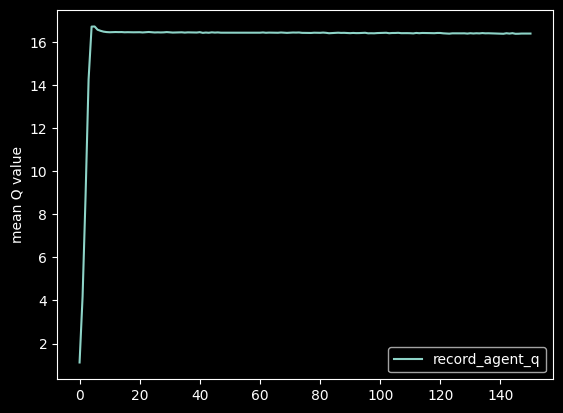

####  Generating test set traces  ####
Q_phys avg: 12.676578
Q_agent avg: 13.352409
Max weight: 0.0004984563222534501
WIS Estimated Return: 1.2115
Behavior Policy Estimated Return: 0.9173
WIS Mean: 1.1190
WIS 95% Confidence Interval: (np.float32(1.0137008), np.float32(1.2373433))
Time used: 1007.9483441


In [ ]:

# Convert and save record_agent_q
record_agent_q_np = [
    q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    for q in record_agent_q
]
# Convert the list to a NumPy array
record_agent_q_np = np.array(record_agent_q_np)
agent_length_list = list(range(len(record_agent_q_np)))
plt.plot(agent_length_list, record_agent_q_np, label='record_agent_q')
np.save('SAC-algorithm/mean_agent_q.npy', record_agent_q_np)

# Convert and save record_phys_q
record_phys_q_np = [
    q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    for q in record_phys_q
]
record_phys_q_np = np.array(record_phys_q_np)  # Ensure it's a NumPy array
phys_length_list = list(range(len(record_phys_q_np)))
np.save('SAC-algorithm/mean_phys_q.npy', record_phys_q_np)

# Plot configurations (if needed)
plt.ylabel("mean Q value")
plt.legend()
plt.show()


# =================测试集，评估test set================================================================
Y90_test = reformat5[test, outcome]
SOFA_test = reformat5[test, 57]
do_test(model, Xtest, actionbloctest, bloctest,
        Y90_test, SOFA_test, reward_value, beta)

elapsed = (time.perf_counter() - start)
print("Time used:", elapsed)
plt.show()

In [ ]:
print(dir(model))  # Untuk melihat atribut apa saja yang ada pada objek model

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'actor', 'actor_optimizer', 'actor_scheduler', 'alpha', 'alpha_optimizer', 'alpha_scheduler', 'critic_1', 'critic_1_optimizer', 'critic_1_scheduler', 'critic_2', 'critic_2_optimizer', 'critic_2_scheduler', 'device', 'gamma', 'get_action', 'log_alpha', 'soft_update', 'target_critic_1', 'target_critic_2', 'target_entropy', 'tau', 'train']


In [ ]:
import torch
import os


def load_model(model_path, state_dim, action_dim):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    # Inisialisasi model SACAgent
    model = SACAgent(state_dim=state_dim, action_dim=action_dim)

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

    # Load state_dict ke masing-masing komponen model
    model.actor.load_state_dict(checkpoint['actor_state_dict'])
    model.critic_1.load_state_dict(checkpoint['critic_1_state_dict'])
    model.critic_2.load_state_dict(checkpoint['critic_2_state_dict'])

    print(f"Model loaded successfully from {model_path}")
    print(
        f"Best mean agent Q from training: {checkpoint['best_mean_agent_q']}")

    return model

In [ ]:
model = load_model('SAC-algorithm/best_model_diff_norm.pt', 37, 2)

Model loaded successfully from SAC-algorithm/best_model_diff_norm.pt
Best mean agent Q from training: 16.717586517333984


C:\Users\asus\AppData\Local\Temp\ipykernel_489684\2278818195.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.devi

In [ ]:
# def inverse_transform_action(norm_action, stats_path='SAC-algorithm/action_norm_stats.pkl'):
#     with open(stats_path, 'rb') as f:
#         stats = pickle.load(f)

#     # Ambil statistik yang benar
#     mean_log_iv = stats['mean_log_iv']
#     std_log_iv = stats['std_log_iv']
#     mean_log_vaso = stats['mean_log_vaso']
#     std_log_vaso = stats['std_log_vaso']

#     # Transformasi balik dari z-score ke log1p domain
#     iv_log = norm_action[:, 0] * std_log_iv + mean_log_iv
#     vaso_log = norm_action[:, 1] * std_log_vaso + mean_log_vaso

#     # Transformasi balik dari log1p ke domain asli
#     iv_raw = np.expm1(iv_log)
#     vaso_log = np.maximum(vaso_log, 0)  # Tidak boleh log1p dari < 0
#     vaso_raw = np.expm1(vaso_log)

#     return np.stack([iv_raw, vaso_raw], axis=1)
def inverse_transform_action(norm_action, stats_path='SAC-algorithm/action_norm_stats.pkl'):
    with open(stats_path, 'rb') as f:
        stats = pickle.load(f)

    mean_log_iv = stats['mean_log_iv']
    std_log_iv = stats['std_log_iv']
    mean_log_vaso = stats['mean_log_vaso']
    std_log_vaso = stats['std_log_vaso']

    # Inverse z-score ke log-domain
    iv_log = norm_action[:, 0] * std_log_iv + mean_log_iv
    vaso_log = norm_action[:, 1] * std_log_vaso + mean_log_vaso

    # Inverse log1p dan ambil abs supaya tidak negatif
    iv_raw = np.abs(np.expm1(iv_log))
    vaso_raw = np.abs(np.expm1(vaso_log))

    return np.stack([iv_raw, vaso_raw], axis=1)




In [ ]:
state = torch.tensor(states[7], dtype=torch.float32).unsqueeze(0)
action = model.get_action(state)
print(action)


[[-0.91429603 -0.99388236]]


In [ ]:
# Ambil batch dari state
states_batch = torch.tensor(states[:100], dtype=torch.float32).to(device)  # (100, state_dim)

# Get action dari model: pastikan ini hasil tanh (dalam [-1, 1])
with torch.no_grad():
    actions_batch = model.get_action(states_batch)  # (100, 2), sudah dalam tanh output

# Pindahkan ke CPU dan ubah ke numpy
actions_batch_np = actions_batch

# Inverse transform ke domain dosis asli
original_actions = inverse_transform_action(actions_batch_np)

# Cetak contoh hasil
for i in range(20):  # Cetak 5 contoh
    print(f"[{i}] Tanh Action:      IV={actions_batch_np[i, 0]:.4f}, Vaso={actions_batch_np[i, 1]:.4f}")
    print(f"     Raw Dosage:     IV={original_actions[i, 0]:.2f} mL, Vaso={original_actions[i, 1]:.4f} mcg/min\n")


[0] Tanh Action:      IV=-0.9799, Vaso=-0.9741
     Raw Dosage:     IV=1.26 mL, Vaso=0.0894 mcg/min

[1] Tanh Action:      IV=-0.6058, Vaso=-0.9846
     Raw Dosage:     IV=4.93 mL, Vaso=0.0907 mcg/min

[2] Tanh Action:      IV=-0.9659, Vaso=-0.9726
     Raw Dosage:     IV=1.34 mL, Vaso=0.0892 mcg/min

[3] Tanh Action:      IV=-0.9351, Vaso=-0.9920
     Raw Dosage:     IV=1.54 mL, Vaso=0.0917 mcg/min

[4] Tanh Action:      IV=-0.5868, Vaso=-0.9937
     Raw Dosage:     IV=5.23 mL, Vaso=0.0919 mcg/min

[5] Tanh Action:      IV=-0.9658, Vaso=-0.7979
     Raw Dosage:     IV=1.35 mL, Vaso=0.0670 mcg/min

[6] Tanh Action:      IV=-0.7411, Vaso=-0.9653
     Raw Dosage:     IV=3.19 mL, Vaso=0.0883 mcg/min

[7] Tanh Action:      IV=-0.9041, Vaso=-0.9747
     Raw Dosage:     IV=1.75 mL, Vaso=0.0895 mcg/min

[8] Tanh Action:      IV=-0.9892, Vaso=-0.9141
     Raw Dosage:     IV=1.21 mL, Vaso=0.0819 mcg/min

[9] Tanh Action:      IV=-0.9032, Vaso=-0.6278
     Raw Dosage:     IV=1.76 mL, Vaso=0.0448

In [ ]:
# Output model (setelah tanh)
state = torch.tensor(states[:100], dtype=torch.float32).unsqueeze(0)
action = model.get_action(state)
# Inverse ke dosis asli (ml/hr dan mcg/min)
original_action = inverse_transform_action(action)

print("Raw model output (tanh):", action)
print("Original action (IV, Vaso):", original_action)


Raw model output (tanh): [[[-8.8408351e-01 -9.9720615e-01]
  [-9.6430063e-01 -9.9255550e-01]
  [-8.4581023e-01 -9.5990509e-01]
  [-9.9547148e-01 -8.9644676e-01]
  [-9.4396490e-01 -9.7041821e-01]
  [-5.5680209e-01 -9.8974395e-01]
  [ 1.8493557e-01 -9.8699701e-01]
  [-9.9237788e-01 -9.6842790e-01]
  [ 9.1869485e-01 -9.4226396e-01]
  [-7.5347495e-01 -9.7464073e-01]
  [-6.5319484e-01 -9.8211670e-01]
  [-9.0633005e-01 -9.4739968e-01]
  [-7.8849334e-01 -9.7401667e-01]
  [-8.3155274e-01 -9.5057791e-01]
  [-8.7693638e-01 -9.7214139e-01]
  [-9.8429585e-01 -9.4436061e-01]
  [ 9.6928257e-01 -9.9883753e-01]
  [-4.0145978e-01 -6.2399071e-01]
  [ 9.4807315e-01 -9.7294587e-01]
  [ 9.8917663e-01 -9.7972530e-01]
  [ 9.2003703e-01 -9.8440921e-01]
  [ 9.5035267e-01 -9.9090970e-01]
  [ 1.8673158e-01 -9.5742059e-01]
  [ 8.3841681e-01 -9.4209236e-01]
  [ 7.6127160e-01 -9.8362690e-01]
  [-6.2541735e-01 -9.7163165e-01]
  [ 7.3042244e-02 -9.6873176e-01]
  [-9.0577471e-01 -9.7859198e-01]
  [-9.9702066e-01 -9.64

In [ ]:
print(states)

[[ 1.7631459  -0.60842407  0.57550041 ... -0.25306864 -2.29741752
  -2.77440114]
 [ 1.7631459  -0.60842407  0.57550041 ... -0.25306864 -0.27875598
  -0.2654923 ]
 [ 1.7631459  -0.60842407  0.57550041 ... -0.25306864  0.00461083
  -0.19041098]
 ...
 [-0.42165687 -0.86222085 -2.3190198  ... -0.75606001  0.4277575
   0.16129233]
 [-0.42165687 -0.86222085 -2.3190198  ... -0.75606001  0.44625096
   0.18952935]
 [-0.42165687 -0.86222085 -2.3190198  ... -0.75606001  0.45579092
   0.21002294]]
